In [1]:
import os
import cv2
import json
import numpy as np

In [6]:
def get_dataset_paths(data_path):
    '''
    Get the file paths for the real and synthetic data
    :param data_path: The path to the data
    :return: real_data_files: The file paths for the real data
             synthetic_data_files: The file paths for the synthetic data
    '''
    # Load all the image file paths for real and synthetic data
    synthetic_data = os.path.join(data_path, "ThisPersonDoesNotExist")
    synthetic_data_files = []
    for dir in os.listdir(synthetic_data):
        synthetic_data_files.extend([os.path.join(synthetic_data, dir, f) for f in os.listdir(os.path.join(synthetic_data, dir))])

    # Load the json subset of the real data
    with open("real_faces_subset.json") as f:
        real_data_json = json.load(f)
    
    # Build the real data file paths
    real_data_files = []
    for file_entry in real_data_json['files']:
        file_name = file_entry.split("/")[-1]
        file_path = os.path.join(data_path, "images1024x1024", file_name)
        real_data_files.append(file_path)
    
    return real_data_files, synthetic_data_files


def load_and_resize_images(file_paths, size=(64, 64)):
    '''
    Load the images from the file paths
    :param file_paths: The file paths to the images
    :return: The images in numpy array format
    '''
    images = []
    for file_path in file_paths:
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, size)
        images.append(image)
    return np.array(images)


def shuffle_data(X, y):
    '''
    Shuffles the data
    :param X: The data
    :param y: The labels
    :return: The shuffled data and labels
    '''
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], y[indices]


def split_data(data):
    '''
    Split the data into training, validation and test sets (60 - 20 - 20 split)
    :param data: The data to split
    :return: The training, validation and test sets
    '''
    return np.split(data, [int(0.6 * len(data)), int(0.8 * len(data))])


def augment_data(X_images, augmentations, n_augmentations=5):
    '''
    Augments the data by selecting from a random augmentation from a set of augmentations to apply to a random image
    This is repeated n_augmentations times
    :param X_images: The images in numpy array format
    :param augmentations: The set of augmentations to apply
    :param n_augmentations: The number of augmentations to apply
    :return: X_images: Dataset with augmented images in numpy array format
    '''
    if n_augmentations == 0:
        return X_images

    augmented_images = []
    for i in range(n_augmentations):
        random_index = np.random.randint(0, len(X_images))
        random_augmentation = np.random.choice(augmentations)
        augmented_images.append(random_augmentation(X_images[random_index]))
    
    return np.concatenate((X_images, augmented_images), axis=0)


def add_random_noise(image):
    '''
    Adds random noise to the image
    :param image: The image to add noise to
    :return: The noisy image
    '''
    # Normalize the image to [0, 1]
    normalized_image = image / 255
    # Add Gaussian noise
    noise = np.random.normal(0, 0.05, normalized_image.shape)
    noisy_image = normalized_image + noise
    # Clip the noisy image to [0, 1]
    noisy_image_clipped = np.clip(noisy_image, 0, 1)
    # Convert the noisy image back to [0, 255]
    return (noisy_image_clipped * 255).astype(np.uint8)


def jitter_image(image):
    '''
    Randomly shifts the image either up, down, left or right by a random small amount of pixels
    :param image: The image to jitter
    :return: The jittered image
    '''
    # Choose a random direction to shift the image
    direction = np.random.choice(["up", "down", "left", "right"])
    # Choose a random amount to shift the image
    amount = np.random.randint(1, 10)
    # Sample a random pixel on the direction edge for the color to use
    # This does not look as good as it sounds
    if direction == "up":
        color = image[0, np.random.randint(0, image.shape[1])]
    elif direction == "down":
        color = image[-1, np.random.randint(0, image.shape[1])]
    elif direction == "left":
        color = image[np.random.randint(0, image.shape[0]), 0]
    else:
        color = image[np.random.randint(0, image.shape[0]), -1]

    # Shift the image and replace the empty space with border color pixels
    if direction == "up":
        jittered_image = np.vstack((np.full((amount, image.shape[1], 3), color), image[:-amount]))
    elif direction == "down":
        jittered_image = np.vstack((image[amount:], np.full((amount, image.shape[1], 3), color)))
    elif direction == "left":
        jittered_image = np.hstack((np.full((image.shape[0], amount, 3), color), image[:, :-amount]))
    else:
        jittered_image = np.hstack((image[:, amount:], np.full((image.shape[0], amount, 3), color)))
    return jittered_image

In [3]:
real_files, synthetic_files = get_dataset_paths("dataset")
real_images = load_and_resize_images(real_files)
synthetic_images = load_and_resize_images(synthetic_files)

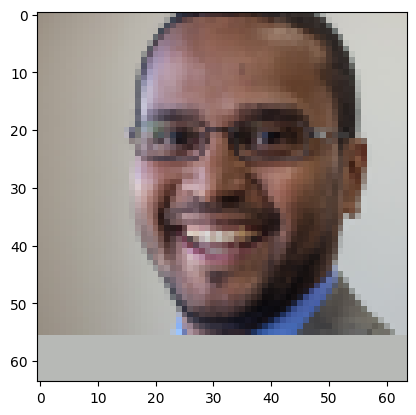

In [4]:
from matplotlib import pyplot as plt
img = real_images[0]
augmentations = [   lambda image: cv2.flip(image, 1),
                    lambda image: add_random_noise(image),
                    lambda image: jitter_image(image)]
img = augmentations[2](img)
plt.imshow(img)
# Not using jitter for now
augmentations = [lambda image: cv2.flip(image, 1),
                 lambda image: add_random_noise(image)]

In [8]:
target_dataset_size = 10000
real_images = augment_data(real_images, augmentations, target_dataset_size - len(real_images))
synthetic_images = augment_data(synthetic_images, augmentations, target_dataset_size - len(synthetic_images))
print(len(real_images))
print(len(synthetic_images))

10000
10000


In [9]:
# Combined Data with associated labels
X = np.concatenate((real_images, synthetic_images))
y = np.concatenate((np.ones(len(real_images)), np.zeros(len(synthetic_images))))

In [10]:
X, y = shuffle_data(X, y)

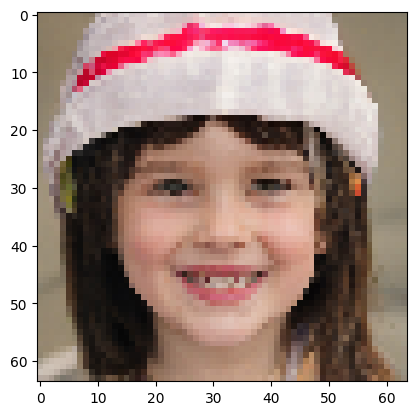

In [12]:
img = X[0]
plt.imshow(img)

In [ ]:
X_train, X_val, X_test = split_data(X)
y_train, y_val, y_test = split_data(y)